# Análisis de los resultados del modelado para Grado

En este análisis se realiza un análisis de los resultados obtenidos con el modelo realizado para los alumnos de Grado.

En este sentido, se ha realizado lo siguiente:

1. Se obtienen las métricas del modelo en el conjunto test.
2. Se observa la matriz de confusión para los matriculados y no matriculados, comparando el real con el predicho.
3. Se comparan las tasas de matriculación obtenidas con el predicho y las reales en las 5 principales titulaciones.
4. Se analizan las distribuciones de la probabilidad en cada una de las distintas etapas.
5. Se mira las distribuciones de la probabilidad de matrícula en las 5 titulaciones top.
6. Se mira la importancia de las variables dentro del modelo utilizado.

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Cargar datos
df = pd.read_excel(r'C:\Users\0017655\Downloads\test_grado_completo_con_scoring.xlsx')

# Configuración estética
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings

# Configuración de limpieza y estilo
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 9)

# --- PROCESAMIENTO DE DATOS ---
# 1. Limpieza de nombres de etapa
df['PL_Etapa__c'] = df['PL_Etapa__c'].astype(str).str.strip()
# 2. Transformación a Probabilidad Real de Matrícula (Escala 0 a 1)
# Si el modelo predice 0 (No matrícula), la prob. real es (1 - score de confianza)


# 3. Definición de Segmentos para Análisis de Bajas
def definir_estado(row):
    if row['desmatriculado'] == 1 and row['target'] == 0:
        return 'Desmatriculado (Baja)'
    if row['target'] == 1:
        return 'Matriculado Activo'
    return 'No Matriculado'

df['estado_final'] = df.apply(definir_estado, axis=1)

#df.to_excel(r'C:\Users\0017655\Downloads\test_grado_completo_con_scoring 3_prob_real.xlsx')

## 1. Resultados globales del modelo de Grado

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def analizar_virtudes_modelo(df):
    """
    Calcula y presenta las métricas clave de rendimiento del modelo 
    enfocadas a la toma de decisiones en Admisiones.
    """
    y_real = df['target']
    y_pred = df['prediction_label']
    y_prob = df['prob_matricula_real']
    
    # Cálculos técnicos
    acc = accuracy_score(y_real, y_pred)
    prec = precision_score(y_real, y_pred)
    rec = recall_score(y_real, y_pred)
    f1 = f1_score(y_real, y_pred)
    auc = roc_auc_score(y_real, y_prob)
    
    # Matriz para cálculo de especificidad
    tn, fp, fn, tp = confusion_matrix(y_real, y_pred).ravel()
    especificidad = tn / (tn + fp)

    print("-" * 50)
    print("      VIRTUDES Y MÉTRICAS DEL MODELO DE ADMISIÓN")
    print("-" * 50)
    print(f"✅ Porcentaje de Acierto (Accuracy): {acc:.2%}")
    print(f"🎯 Capacidad de Discriminación (AUC-ROC): {auc:.4f}")
    print(f"📊 Precisión (Cuando predice Sí, ¿cuánto acierta?): {prec:.2%}")
    print(f"📈 Sensibilidad (¿A cuántos del total captura?): {rec:.2%}")
    print(f"🛡️ Especificidad (Capacidad de detectar No-Matrícula): {especificidad:.2%}")
    print("-" * 50)
    
    # Interpretación estratégica para el informe
    print("\nANÁLISIS ESTRATÉGICO:")
    if auc > 0.9:
        print("⭐ El modelo tiene un rendimiento EXCELENTE. La separación entre perfiles es muy clara.")
    elif auc > 0.8:
        print("👍 El modelo es ROBUSTO y fiable para la planificación financiera y de plazas.")
        
    print(f"💡 De cada 100 matrículas reales, el modelo identifica correctamente a {int(rec*100)} candidatos.")
    print(f"💡 El modelo es especialmente bueno descartando (Especificidad: {especificidad:.2%}), lo que ahorra esfuerzo comercial.")
    print("-" * 50)

# Ejecución de la función
analizar_virtudes_modelo(df)

--------------------------------------------------
      VIRTUDES Y MÉTRICAS DEL MODELO DE ADMISIÓN
--------------------------------------------------
✅ Porcentaje de Acierto (Accuracy): 93.75%
🎯 Capacidad de Discriminación (AUC-ROC): 0.9751
📊 Precisión (Cuando predice Sí, ¿cuánto acierta?): 91.97%
📈 Sensibilidad (¿A cuántos del total captura?): 94.79%
🛡️ Especificidad (Capacidad de detectar No-Matrícula): 92.85%
--------------------------------------------------

ANÁLISIS ESTRATÉGICO:
⭐ El modelo tiene un rendimiento EXCELENTE. La separación entre perfiles es muy clara.
💡 De cada 100 matrículas reales, el modelo identifica correctamente a 94 candidatos.
💡 El modelo es especialmente bueno descartando (Especificidad: 92.85%), lo que ahorra esfuerzo comercial.
--------------------------------------------------


## 2. Matriz de confusión global

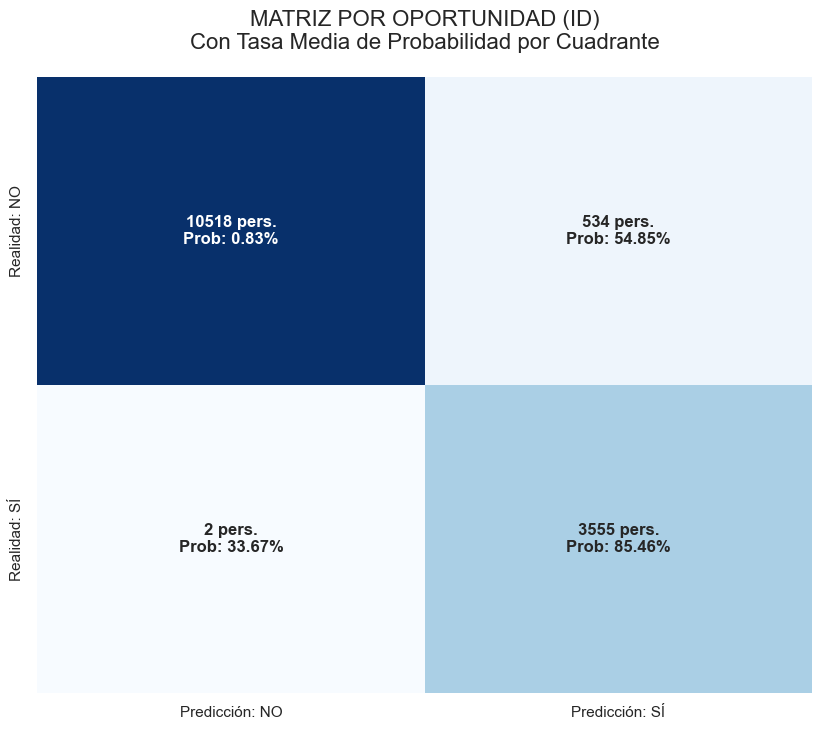

Exactitud (Accuracy): 96.33%
Precisión (Certeza de Matrícula): 86.94%


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Calculamos la probabilidad media por oportunidad (ID)
# Esto colapsa todas las etapas de un mismo alumno en un solo valor de propensión
df_oportunidades = df.groupby('ID').agg({
    'target': 'max',             # Si se matriculó en alguna etapa, es 1
    'prediction_label': 'max',    # Si el modelo predijo matrícula en alguna etapa
    'prob_matricula_real': 'mean' # Tasa media de probabilidad del alumno
}).reset_index()

# 2. Calculamos la matriz de confusión basada en IDs Únicos (Personas, no etapas)
cm = confusion_matrix(df_oportunidades['target'], df_oportunidades['prediction_label'])

# 3. Calculamos la tasa media de probabilidad para cada cuadrante de la matriz
tasa_cuadrantes = []
for real in [0, 1]:
    fila = []
    for pred in [0, 1]:
        mask = (df_oportunidades['target'] == real) & (df_oportunidades['prediction_label'] == pred)
        valor_medio = df_oportunidades[mask]['prob_matricula_real'].mean()
        fila.append(valor_medio)
    tasa_cuadrantes.append(fila)

# 4. Visualización
plt.figure(figsize=(10, 8))
# Usamos annot para poner tanto el conteo de personas como su probabilidad media
labels = [
    [f"{cm[0,0]} pers.\nProb: {tasa_cuadrantes[0][0]:.2%}", f"{cm[0,1]} pers.\nProb: {tasa_cuadrantes[0][1]:.2%}"],
    [f"{cm[1,0]} pers.\nProb: {tasa_cuadrantes[1][0]:.2%}", f"{cm[1,1]} pers.\nProb: {tasa_cuadrantes[1][1]:.2%}"]
]

sns.heatmap(cm, annot=labels, fmt="", cmap='Blues', cbar=False,
            xticklabels=['Predicción: NO', 'Predicción: SÍ'],
            yticklabels=['Realidad: NO', 'Realidad: SÍ'],
            annot_kws={"size": 12, "weight": "bold"})

plt.title('MATRIZ POR OPORTUNIDAD (ID)\nCon Tasa Media de Probabilidad por Cuadrante', fontsize=16, pad=20)
plt.show()

# Métricas rápidas para el informe
total = cm.sum()
accuracy = (cm[0,0] + cm[1,1]) / total
precision = cm[1,1] / (cm[1,1] + cm[0,1])
print(f"Exactitud (Accuracy): {accuracy:.2%}")
print(f"Precisión (Certeza de Matrícula): {precision:.2%}")

Aquí se puede observar que el modelo acierta en el 91% de los casos y que, dentro de los matriculados, acierta en casi el 90% de los casos.

## 3. Comparación tasa real de matriculación con la predicha en el top 5 de titulaciones

--------------------------------------------------
      VIRTUDES DEL MODELO (SOBRE OPORTUNIDADES ÚNICAS)
--------------------------------------------------
✅ Exactitud Global (Accuracy): 95.96%
🎯 Área bajo la curva (AUC): 0.9858
📊 Precisión de Matrícula: 90.77%
📈 Capacidad de Captación (Recall): 92.86%
--------------------------------------------------


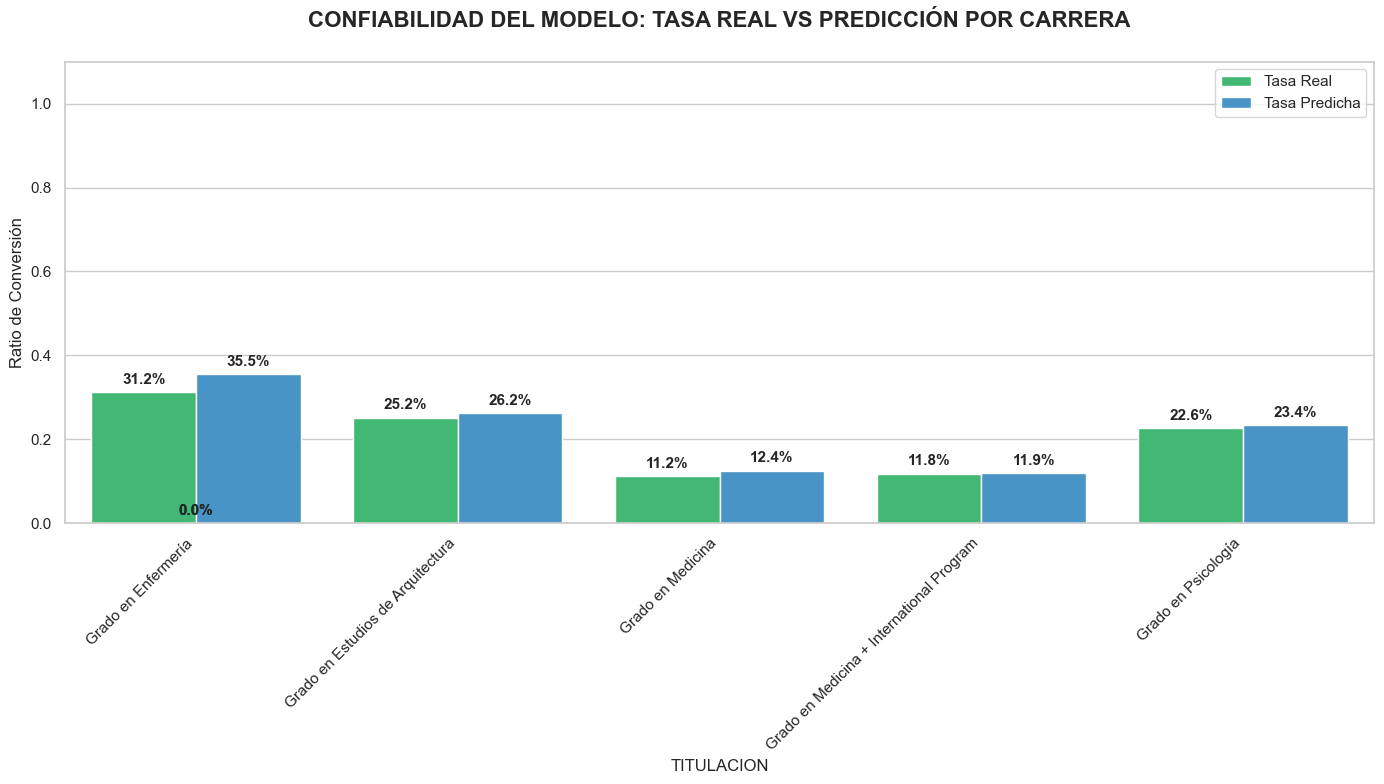

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

# --- 1. PREPARACIÓN DE DATOS POR ID ÚNICO ---
# Agrupamos por ID para que cada oportunidad cuente solo una vez
# Target: tomamos el max (si alguna vez fue 1, es matrícula)
# Prediction_label: tomamos el último estado predicho
# Prob_matricula: tomamos la media o la última (usaremos la real normalizada)

df_unique = df.sort_values(['ID', 'PL_Etapa__c']).groupby('ID').agg({
    'target': 'max',
    'prediction_label': 'last',
    'prob_matricula_real': 'last',
    'TITULACION': 'first'
}).reset_index()



# --- 2. FUNCIÓN DE VIRTUDES DEL MODELO (Basada en IDs Únicos) ---
def analizar_virtudes_modelo(data):
    y_real = data['target']
    y_pred = data['prediction_label']
    y_prob = data['prob_matricula_real']
    
    acc = accuracy_score(y_real, y_pred)
    auc = roc_auc_score(y_real, y_prob)
    prec = precision_score(y_real, y_pred)
    rec = recall_score(y_real, y_pred)
    
    print("-" * 50)
    print("      VIRTUDES DEL MODELO (SOBRE OPORTUNIDADES ÚNICAS)")
    print("-" * 50)
    print(f"✅ Exactitud Global (Accuracy): {acc:.2%}")
    print(f"🎯 Área bajo la curva (AUC): {auc:.4f}")
    print(f"📊 Precisión de Matrícula: {prec:.2%}")
    print(f"📈 Capacidad de Captación (Recall): {rec:.2%}")
    print("-" * 50)

analizar_virtudes_modelo(df_unique)

# --- 3. COMPARATIVA POR TITULACIÓN (TOP 5) ---
top_5_tit = df_unique.groupby('TITULACION')['ID'].nunique().nlargest(5).index
df_top5_unique = df_unique[df_unique['TITULACION'].isin(top_5_tit)]

# Ahora las medias son reales (alumnos matriculados / alumnos totales)
comparativa_tit = df_top5_unique.groupby('TITULACION')[['target', 'prediction_label']].mean().reset_index()
df_plot = comparativa_tit.melt(id_vars='TITULACION', var_name='Tipo', value_name='Tasa')
df_plot['Tipo'] = df_plot['Tipo'].replace({'target': 'Tasa Real', 'prediction_label': 'Tasa Predicha'})

# --- 4. GRÁFICO FINAL ---
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='TITULACION', y='Tasa', hue='Tipo', data=df_plot, palette=['#2ecc71', '#3498db'])

# Añadir etiquetas de porcentaje
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1%}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 9), 
                textcoords = 'offset points', fontsize=11, fontweight='bold')

plt.title('CONFIABILIDAD DEL MODELO: TASA REAL VS PREDICCIÓN POR CARRERA', fontsize=16, fontweight='bold', pad=25)
plt.ylabel('Ratio de Conversión')
plt.ylim(0, 1.1)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Aquí se puede observar que las tasas de matriculación con la variable predicha son muy muy parecidas a las reales y, ligeramente superiores.

In [40]:
df_filtered.columns.tolist

<bound method IndexOpsMixin.tolist of Index(['ACCOUNTID', 'ID', 'ID18__PC', 'target', 'desmatriculado',
       'PL_CURSO_ACADEMICO', 'CH_NACIONAL', 'NU_NOTA_MEDIA_ADMISION',
       'NU_NOTA_MEDIA_1_BACH__PC', 'CH_PRUEBAS_CALIFICADAS',
       'NU_RESULTADO_ADMISION_PUNTOS', 'PL_RESOLUCION_DEFINITIVA',
       'TITULACION', 'CENTROENSENANZA', 'MINIMUMPAYMENTPAYED', 'PAID_AMOUNT',
       'PAID_PERCENT', 'CH_PAGO_SUPERIOR', 'CH_MATRICULA_SUJETA_BECA',
       'CH_AYUDA_FINANCIACION', 'CU_IMPORTE_TOTAL', 'CH_VISITACAMPUS__PC',
       'CH_ENTREVISTA_PERSONAL__PC', 'ACC_DTT_FECHAULTIMAACTIVIDAD',
       'NU_PREFERENCIA', 'STAGENAME', 'PL_SUBETAPA', 'CH_HIJO_EMPLEADO__PC',
       'CH_HIJO_PROFESOR_ASOCIADO__PC', 'CH_HERMANOS_ESTUDIANDO_UNAV__P',
       'CH_HIJO_MEDICO__PC', 'YEARPERSONBIRTHDATE', 'NAMEX',
       'CH_FAMILIA_NUMEROSA__PC', 'PL_SITUACION_SOCIO_ECONOMICA', 'LEADSOURCE',
       'PL_ORIGEN_DE_SOLICITUD', 'PL_PLAZO_ADMISION', 'RECORDTYPENAME',
       'PLAZO_ADMISION_LIMPIO', 'FO_renta

## 4. Evolución de la probabilidad de matrícula por etapa

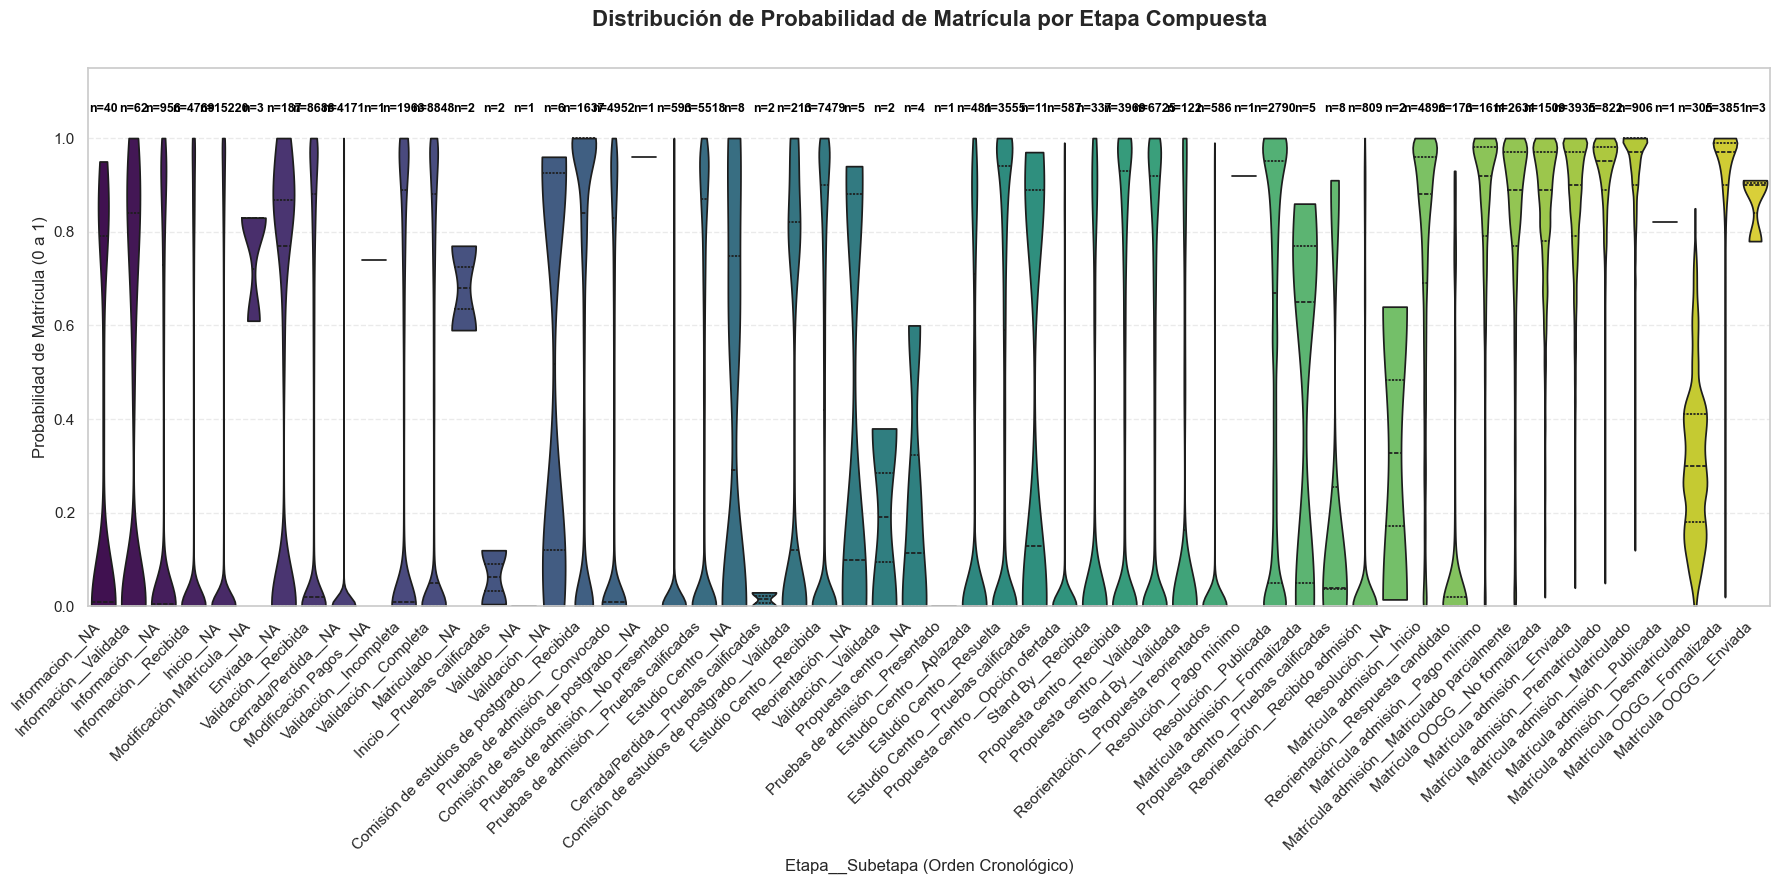

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 1. Configuración de limpieza
warnings.filterwarnings('ignore')

# 2. Preparación de la etapa compuesta (Aseguramos que coincida con la lógica anterior)
df['etapa_compuesta'] = (
    df['PL_Etapa__c'].fillna("NA").astype(str).str.strip() + "__" +
    df['PL_Subetapa__c'].fillna("NA").astype(str).str.strip()
)

# 3. Obtener el orden lógico basado en la columna numérica que ya creamos
# Creamos una lista de las etapas únicas ordenadas por su valor ordinal
etapas_ordenadas = (
    df[['etapa_compuesta', 'etapa_ordinal_num']]
    .drop_duplicates()
    .sort_values(by='etapa_ordinal_num')['etapa_compuesta']
    .tolist()
)

# Convertimos la columna en categórica con el orden específico
df['etapa_compuesta'] = pd.Categorical(
    df['etapa_compuesta'], 
    categories=etapas_ordenadas, 
    ordered=True
)

# 4. Creación del Gráfico de Violín
plt.figure(figsize=(18, 9)) # Un poco más ancho por los nombres largos

ax = sns.violinplot(
    x='etapa_compuesta', 
    y='prob_matricula_real', 
    data=df, 
    palette='viridis', # Cambio a viridis para mejor contraste en gradientes
    inner='quartile', 
    bw_adjust=.5,
    cut=0 
)

# 5. Añadir el conteo de oportunidades (n=X) sobre cada violín
counts = df['etapa_compuesta'].value_counts().reindex(etapas_ordenadas)
for i, count in enumerate(counts):
    if not pd.isna(count) and count > 0:
        ax.text(i, 1.05, f'n={int(count)}', ha='center', va='bottom', 
                fontweight='bold', size=9, color='black')

# 6. Estética y Formato
plt.title('Distribución de Probabilidad de Matrícula por Etapa Compuesta', fontsize=16, fontweight='bold', pad=30)
plt.xlabel('Etapa__Subetapa (Orden Cronológico)', fontsize=12)
plt.ylabel('Probabilidad de Matrícula (0 a 1)', fontsize=12)

# Rotación de etiquetas para legibilidad
plt.xticks(rotation=45, ha='right')

# Ajuste de límites y cuadrícula
plt.ylim(0, 1.15) 
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

Aquí se pueden ver que hay etapas en las que claramente, la probabilidad de matrícula son muy bajas. En cambio, en la etapa de Matrícula admisión, ya se ven probabilidades más extendidas, y que es una de las etapas críticas, ya que hay muchos valores bajos como altos. Sin embargo, en la etapa Matrícula OOGG ya se tienen todas las probabilidades concentradas en valores muy altos.

In [ ]:
import pandas as pd

# 1. Definimos el diccionario de orden basado en TUS etapas reales
orden_admision = {
    'Inicio__NA': 0,
    'Enviada__NA': 1,
    'Validación__Recibida': 2,
    'Validación__Incompleta': 3,
    'Validación__Completa': 4,
    'Estudio Centro__Recibida': 5,
    'Comisión de estudios de postgrado__Recibida': 6,
    'Comisión de estudios de postgrado__Validada': 7,
    'Propuesta centro__Recibida': 8,
    'Propuesta centro__Validada': 9,
    'Pruebas de admisión__Convocado': 10,
    'Pruebas de admisión__No presentado': 11,
    'Resolución__NA': 12,
    'Resolución__Publicada': 13,
    'Matrícula Admisión__Inicio': 14,
    'Matrícula Admisión__Enviada': 15,
    'Matrícula Admisión__Prematriculado': 16,
    'Matrícula Admisión__Pago mínimo': 17,
    'Matrícula Admisión__Matriculado parcialmente': 18,
    'Matrícula OOGG__Formalizada': 19,
    'Matrícula OOGG__No formalizada': 20,
    'Matrícula Admisión__Desmatriculado': 21,
    'Cerrada/Perdida__NA': 22,
    'Stand By__Validada': 23,
    'Reorientación__Respuesta candidato': 24
}

# 2. Aplicar el orden al DataFrame
df['etapa_ordinal_num'] = df['etapa_compuesta'].map(orden_admision)

# 3. Ver el camino que recorre cada Oportunidad (ID)
# (Cambiamos 'ID' por el nombre de tu columna identificadora, ej: 'OpportunityId')
col_id = 'ID' 

flujo_por_id = (
    df.sort_values([col_id, 'etapa_ordinal_num'])
    .groupby(col_id)['etapa_compuesta']
    .apply(lambda x: ' -> '.join(x.unique()))
    .reset_index()
)

print("Ejemplo de flujos encontrados:")
print(flujo_por_id.head(10))

# 4. Verificar si hay etapas que se quedaron sin número (NaN)
faltantes = df[df['etapa_ordinal_num'].isna()]['etapa_compuesta'].unique()
if len(faltantes) > 0:
    print(f"\nOjo, estas etapas no estaban en el diccionario: {faltantes}")

In [ ]:
import pandas as pd

# 1. Aseguramos que la columna etapa_compuesta esté creada y limpia
df['STAGENAME'] = df['STAGENAME'].astype(str).str.strip().replace('nan', 'NA')
df['PL_SUBETAPA'] = df['PL_SUBETAPA'].astype(str).str.strip().replace('nan', 'NA')
df['etapa_compuesta'] = df['STAGENAME'] + "__" + df['PL_SUBETAPA']
print(df['etapa_compuesta'].unique().tolist())

# 2. Mapeamos el orden (basado en tu lógica previa)

df['etapa_ordinal_num'] = df['etapa_compuesta'].map(orden_etapas)

# 3. Agrupamos por ID de oportunidad para ver su histórico
# Nota: Sustituye 'OpportunityID' por el nombre real de tu columna de ID
resumen_etapas = (
    df.sort_values(by=['ID', 'etapa_ordinal_num'])
    .groupby('ID')['etapa_compuesta']
    .apply(lambda x: ' -> '.join(x.unique()))
    .reset_index()
)

# Mostramos los primeros resultados
print("Flujo de etapas por oportunidad:")
print(resumen_etapas.head(10))

['Cerrada/Perdida__NA', 'Matrícula Admisión__Inicio', 'Inicio__NA', 'Matrícula OOGG__Formalizada', 'Reorientación__Respuesta candidato', 'Pruebas de admisión__No presentado', 'Validación__Incompleta', 'Resolución__Publicada', 'Matrícula Admisión__Matriculado parcialmente', 'Matrícula Admisión__Desmatriculado', 'Resolución__NA', 'Estudio Centro__Recibida', 'Comisión de estudios de postgrado__Validada', 'Stand By__Validada', 'Matrícula Admisión__Prematriculado', 'Matrícula OOGG__No formalizada', 'Comisión de estudios de postgrado__Recibida', 'Enviada__NA', 'Validación__Recibida', 'Matrícula Admisión__Pago mínimo', 'Pruebas de admisión__Convocado', 'Cerrada/Perdida__Pruebas calificadas', 'Propuesta centro__Validada', 'Matrícula Admisión__Enviada', 'Validación__Completa', 'Propuesta centro__Recibida']
Flujo de etapas por oportunidad:
                   ID                     etapa_compuesta
0  0066900001VRQMIAA5                 Cerrada/Perdida__NA
1  0066900001W0Y3GAAV          Matrícula A

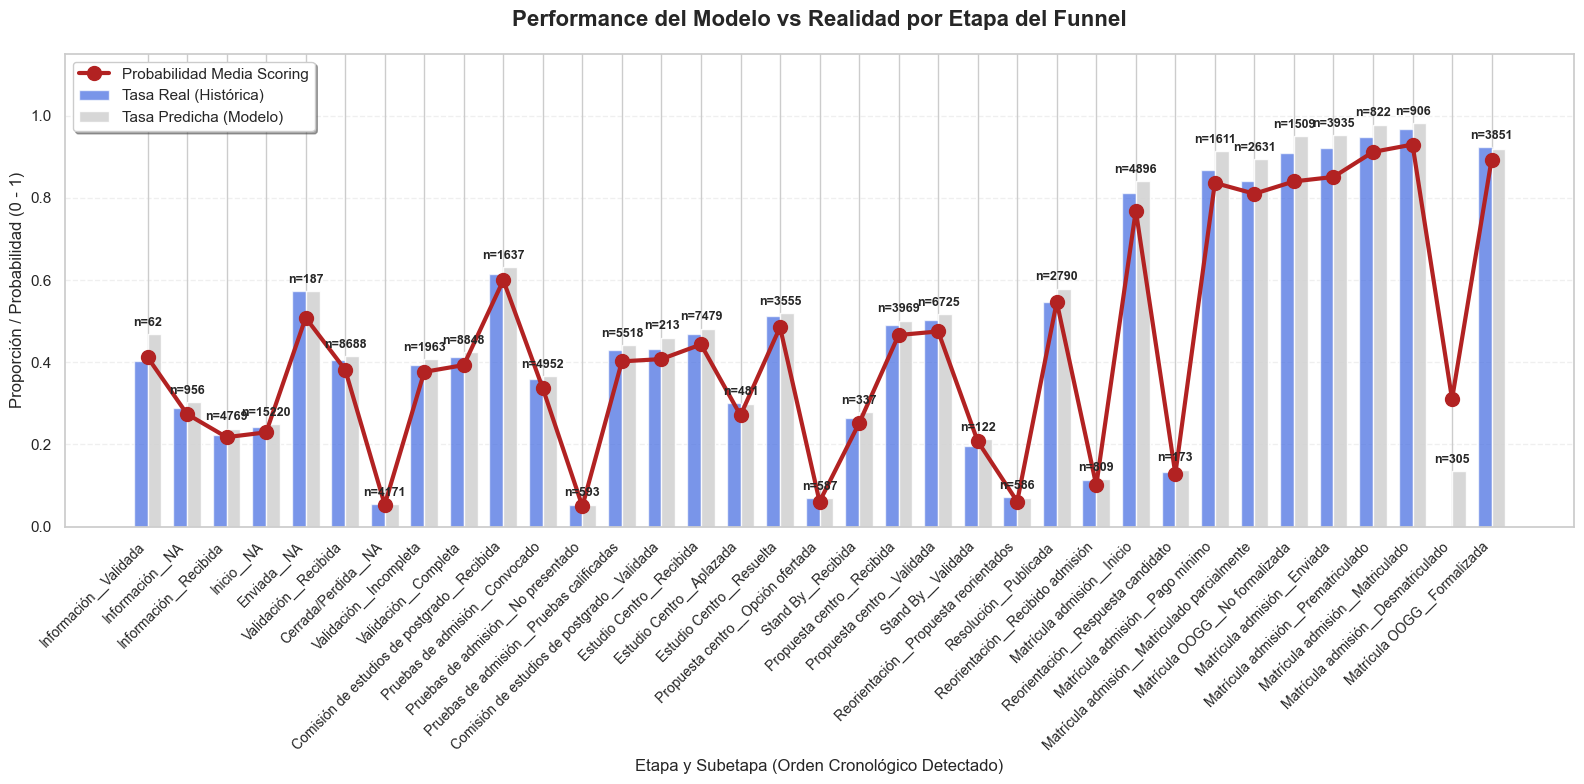


📋 RESUMEN DE MÉTRICAS POR ETAPA ORDENADA:
                             etapa_compuesta  tasa_real  prediction_label  prob_matricula_real  num_casos
                       Información__Validada   0.403226          0.467742             0.412229         62
                             Información__NA   0.289749          0.303347             0.273932        956
                       Información__Recibida   0.223737          0.238415             0.217743       4769
                                  Inicio__NA   0.243693          0.248949             0.229543      15220
                                 Enviada__NA   0.572193          0.572193             0.508244        187
                        Validación__Recibida   0.404351          0.415631             0.381749       8688
                         Cerrada/Perdida__NA   0.054184          0.055862             0.053855       4171
                      Validación__Incompleta   0.392766          0.408049             0.376606       1963
   

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparación de Columnas (Aseguramos que etapa_compuesta sea string)
df['etapa_compuesta'] = df['etapa_compuesta'].astype(str)

# 2. Cálculo de la Tabla de Métricas
# Agrupamos por la etapa_compuesta y usamos la media del orden numérico para clasificar
df_stats = df.groupby('etapa_compuesta').agg({
    'target': 'mean',                # Tasa de matriculación real
    'prediction_label': 'mean',      # Tasa de matriculación predicha (0 o 1)
    'prob_matricula_real': 'mean',   # Media de probabilidad (0.0 a 1.0)
    'etapa_ordinal_num': 'mean',     # El orden calculado automáticamente
    'ID': 'size'                     # Conteo de casos (N)
}).reset_index()

# Renombrar columnas para claridad
df_stats = df_stats.rename(columns={'ID': 'num_casos', 'target': 'tasa_real'})

# 3. Filtro de Volumen y Ordenación
# --- FILTRO: Eliminar etapas con menos de 50 casos para evitar ruido estadístico ---
df_stats = df_stats[df_stats['num_casos'] >= 50]

# --- ORDENACIÓN: Usamos el orden automático que ya calculamos ---
df_stats = df_stats.sort_values('etapa_ordinal_num')

# 4. Visualización Comparativa (Barras + Línea)
if not df_stats.empty:
    plt.figure(figsize=(16, 8))
    
    # Definición de posiciones en el eje X
    x_labels = df_stats['etapa_compuesta'].tolist()
    indices = np.arange(len(x_labels))
    ancho_barras = 0.35

    # Barras: Tasa Real vs Predicha
    plt.bar(indices - ancho_barras/2, df_stats['tasa_real'], 
            width=ancho_barras, label='Tasa Real (Histórica)', color='royalblue', alpha=0.7)
    
    plt.bar(indices + ancho_barras/2, df_stats['prediction_label'], 
            width=ancho_barras, label='Tasa Predicha (Modelo)', color='lightgray', alpha=0.9)

    # Línea: Probabilidad Media del Modelo
    # Esta línea indica qué tan convencido está el modelo en cada etapa
    plt.plot(indices, df_stats['prob_matricula_real'], 
             marker='o', color='firebrick', linewidth=3, label='Probabilidad Media Scoring', markersize=10)

    # Configuración de etiquetas y formato
    plt.xticks(indices, x_labels, rotation=45, ha='right', fontsize=10)
    plt.title('Performance del Modelo vs Realidad por Etapa del Funnel', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Proporción / Probabilidad (0 - 1)', fontsize=12)
    plt.xlabel('Etapa y Subetapa (Orden Cronológico Detectado)', fontsize=12)
    
    # Anotación del volumen (n) sobre las barras
    for i, row in df_stats.reset_index(drop=True).iterrows():
        plt.text(i, max(row['tasa_real'], row['prediction_label']) + 0.02, 
                 f"n={int(row['num_casos'])}", ha='center', fontsize=9, fontweight='bold')

    plt.ylim(0, 1.15)
    plt.legend(loc='upper left', frameon=True, shadow=True)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # 5. Reporte tabular final
    print("\n📋 RESUMEN DE MÉTRICAS POR ETAPA ORDENADA:")
    columnas_reporte = ['etapa_compuesta', 'tasa_real', 'prediction_label', 'prob_matricula_real', 'num_casos']
    print(df_stats[columnas_reporte].to_string(index=False))
else:
    print("⚠️ No hay suficientes datos (n >= 50) para generar la comparativa.")

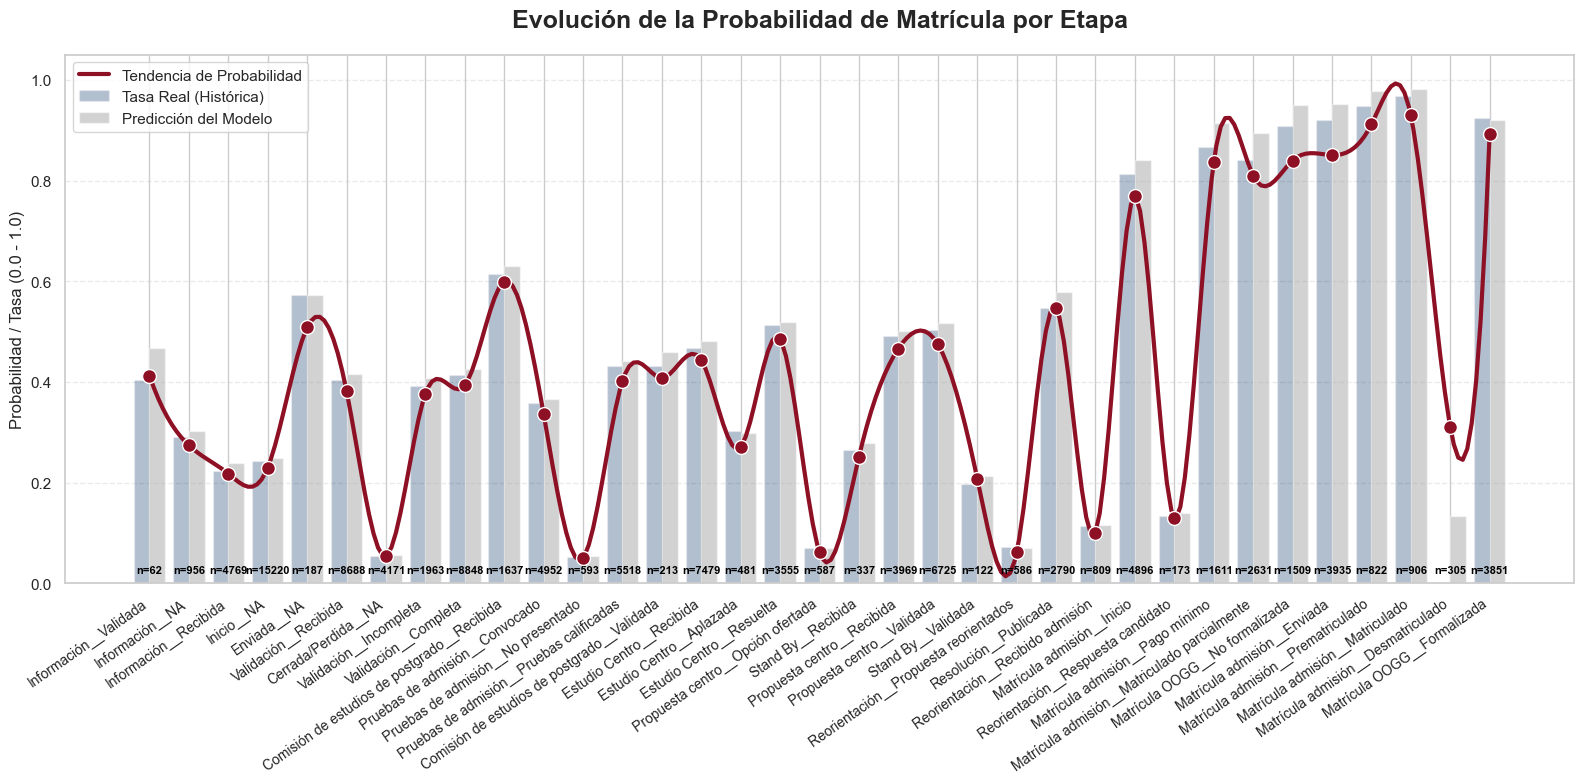

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# --- PREPARACIÓN DE DATOS (Basado en tu lógica) ---
# Ordenar por el flujo lógico
df_stats = df_stats.sort_values('etapa_ordinal_num').dropna(subset=['etapa_ordinal_num'])

if not df_stats.empty:
    plt.figure(figsize=(16, 8))
    x_labels = df_stats['etapa_compuesta'].tolist()
    indices = np.arange(len(x_labels))
    
    # 1. BARRAS: Tasa Real vs Predicha
    plt.bar(indices - 0.2, df_stats['tasa_real'], width=0.4, 
            label='Tasa Real (Histórica)', color='#002C5F', alpha=0.3) # Azul UNAV suave
    plt.bar(indices + 0.2, df_stats['prediction_label'], width=0.4, 
            label='Predicción del Modelo', color='#A6A6A6', alpha=0.5) # Gris neutro

    # 2. CURVA SUAVIZADA (Spline Interpolation)
    # Generamos más puntos para que la curva sea fluida
    x_new = np.linspace(indices.min(), indices.max(), 300) 
    y_prob = df_stats['prob_matricula_real'].values
    
    spl = make_interp_spline(indices, y_prob, k=3) # k=3 para suavizado cúbico
    y_smooth = spl(x_new)

    # 3. DIBUJAR CURVA Y PUNTOS REALES
    plt.plot(x_new, y_smooth, color='#8E1024', linewidth=3, label='Tendencia de Probabilidad') # Granate UNAV
    plt.scatter(indices, y_prob, color='#8E1024', s=100, zorder=5, edgecolors='white') # Puntos sobre la curva

    # Estética de la Slide
    plt.xticks(indices, x_labels, rotation=35, ha='right', fontsize=10)
    plt.title('Evolución de la Probabilidad de Matrícula por Etapa', fontsize=18, fontweight='bold', pad=20)
    plt.ylabel('Probabilidad / Tasa (0.0 - 1.0)', fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    
    # Añadir etiquetas de N (Casos) sobre las barras para dar contexto técnico
    for i, val in enumerate(df_stats['num_casos']):
        plt.text(i, 0.02, f'n={val}', ha='center', fontsize=8, color='black', fontweight='bold')

    plt.legend(frameon=True, facecolor='white', fontsize=11)
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos suficientes para visualizar.")

## Distribución de probabilidades en el top 5 de titulaciones

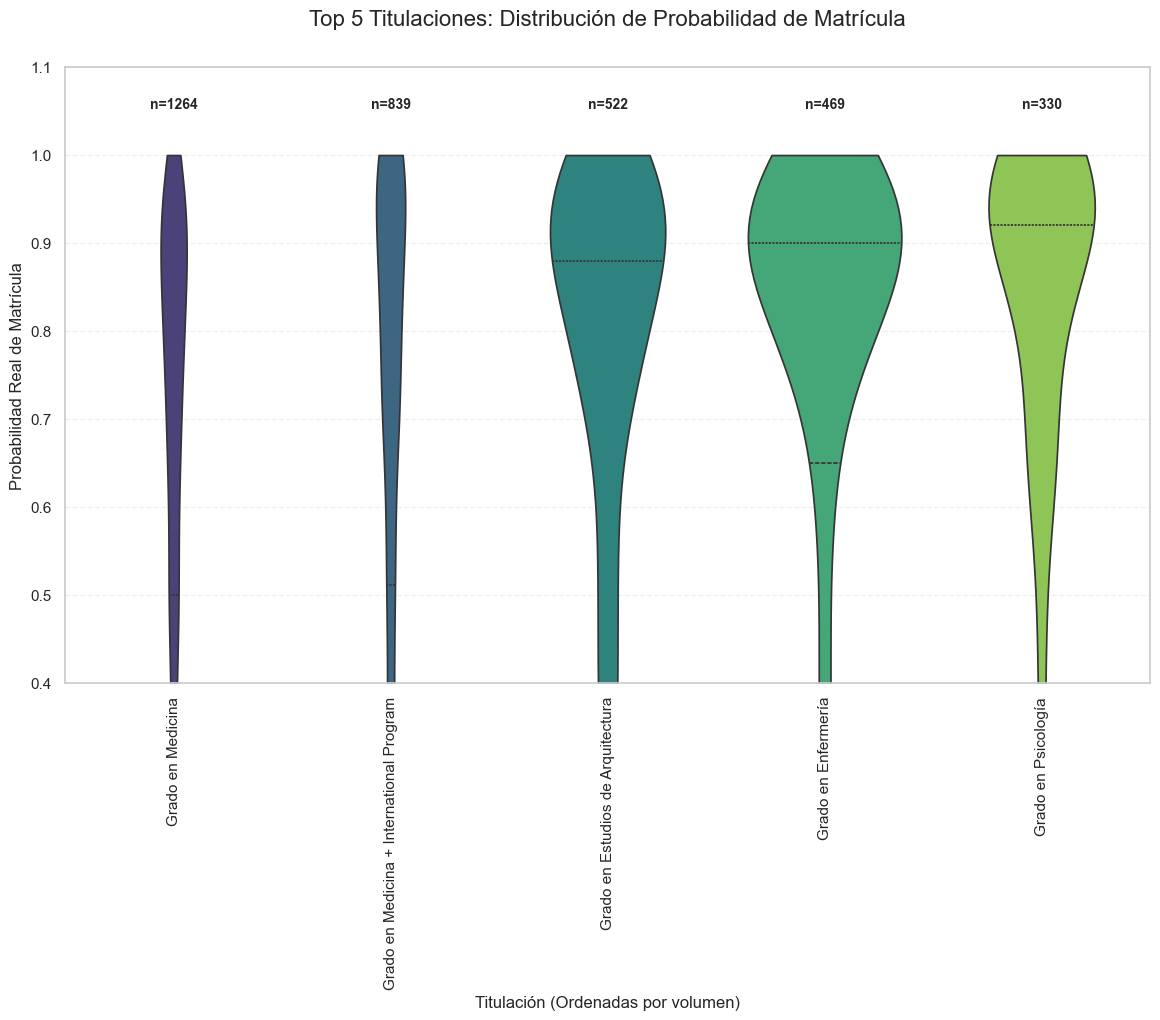

In [ ]:
# 1. Identificar el Top 5 de Titulaciones por IDs únicos
top_5_titulaciones = df.groupby('TITULACION')['ID'].nunique().nlargest(5).index
df_top5 = df[df['TITULACION'].isin(top_5_titulaciones)].copy()

# 2. Gráfico de Violín para el Top 5
plt.figure(figsize=(14, 8))

ax = sns.violinplot(
    x='TITULACION', 
    y='prob_matricula_real', 
    data=df_top5,
    palette='viridis',
    inner='quartile',
    cut=0
)

# Añadir n=X (IDs únicos) encima de cada violín
counts_tit = df_top5.groupby('TITULACION')['ID'].nunique()
for i, tit in enumerate(top_5_titulaciones):
    n = counts_tit[tit]
    ax.text(i, 1.05, f'n={n}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.title('Top 5 Titulaciones: Distribución de Probabilidad de Matrícula', fontsize=16, pad=30)
plt.ylabel('Probabilidad Real de Matrícula')
plt.xlabel('Titulación (Ordenadas por volumen)')
plt.ylim(0.4, 1.1)
plt.xticks(rotation=90) # Verticales para que se lean los grados largos
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

Aquí se puede obserbar que los patrones son muy distintos:

- Medicina: Es fino y constante, lo que implica que el modelo es robusto y que, la mayoría de alumnos interesados siguen el mismo patrón y el modelo les da probabilidades idénticas.
- Arquitectura, Enfermería y Psicología: Hay mñas variabilidad en las probabilidades, aunque se concentren en probabilidades más altas

## Importancia de variables

Transformation Pipeline and Model Successfully Loaded


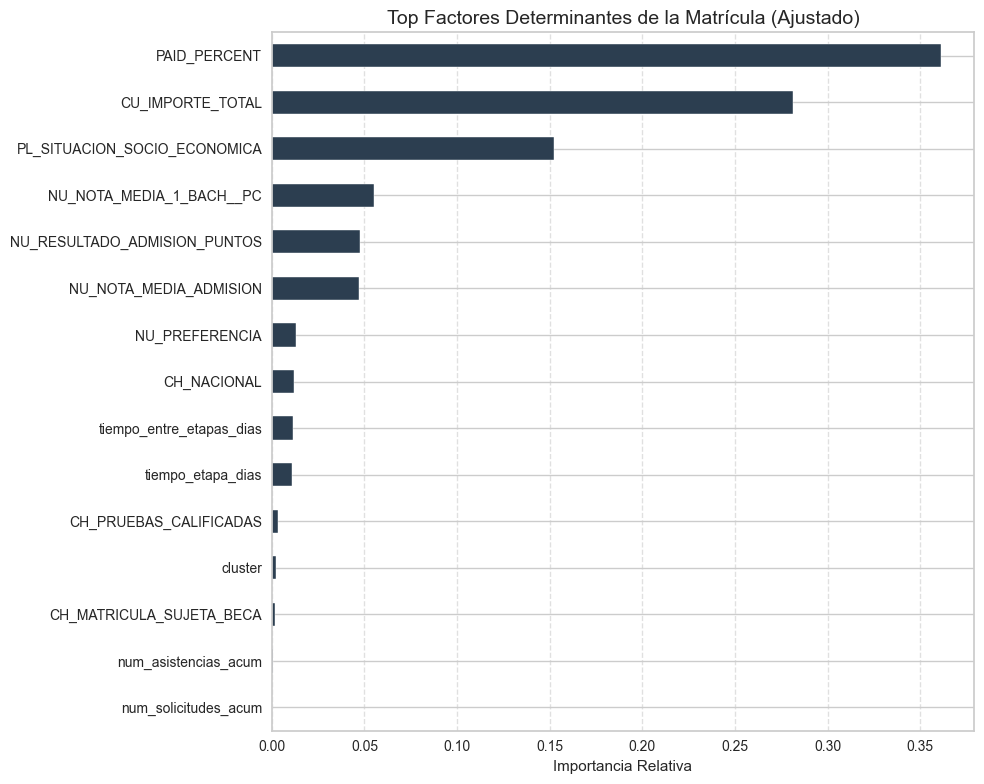

In [ ]:

from pycaret.classification import (load_model,
    setup, compare_models, tune_model,
    predict_model, plot_model, save_model
)

ruta_modelo = r"C:\Users\0017655\Downloads\modelo_final_grado 6"
modelo = load_model(ruta_modelo)
# 2. Inicializar el experimento (Necesario para que plot_model funcione)
# 'data' debe ser el DataFrame que estás usando para la PoC
# 'target' debe ser el nombre de la columna que quieres predecir
s = setup(data = df, target = 'target', session_id = 123, verbose=False)
import pandas as pd
import matplotlib.pyplot as plt

# 1. Obtener el modelo final
last_step_name = list(modelo.named_steps.keys())[-1]
final_model = modelo.named_steps[last_step_name]

# 2. Extraer valores de importancia
importancia_valores = final_model.feature_importances_
n_features = len(importancia_valores)

# 3. Intentar recuperar nombres, si no, crear genéricos
try:
    # Intentamos obtener los nombres que el transformador final dejó
    feature_names = modelo.feature_names_in_
    
    # Si la longitud sigue sin coincidir, ajustamos
    if len(feature_names) != n_features:
        #print(f"⚠️ Ajustando: Modelo tiene {n_features} variables pero se detectaron {len(feature_names)} nombres.")
        if len(feature_names) > n_features:
            feature_names = feature_names[:n_features]
        else:
            feature_names = list(feature_names) + [f"Extra_Feature_{i}" for i in range(n_features - len(feature_names))]
except:
    feature_names = [f"Variable_{i}" for i in range(n_features)]

# 4. Crear el gráfico con seguridad
importancias = pd.Series(importancia_valores, index=feature_names)

plt.figure(figsize=(10, 8))
# Tomamos las 15 más importantes (o el máximo disponible)
top_n = min(15, n_features)
importancias.nlargest(top_n).sort_values().plot(kind='barh', color='#2c3e50')

plt.title('Top Factores Determinantes de la Matrícula (Ajustado)', fontsize=14)
plt.xlabel('Importancia Relativa')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Aquí se puede observar que las variables más importantes son: El importe total de la matrícula, el porcentaje que haya pagado y la situación socioeconómica. Seguido de las notas, tanto de bachillerato como de admisión. Luego, está el número de preferencia de la carrera.